In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;  
}

<IPython.core.display.Javascript object>

In [2]:
import sys
sys.path.append('/Users/af/Work/code/mcmc/build')
#sys.path.append('/Users/af/Work/code/mcmc/debug')

import mcmc
#help(mcmc)
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
from datetime import datetime,timedelta
giturl_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

corona_cases_df=pd.read_csv(giturl_deaths, index_col=[0,1,2,3])  
#   use first four columns as multiindex




country_official_list = (corona_cases_df.index.get_level_values('Country/Region').values)

wanted_countries = ['China', 'Korea','Italy', 'France', 'US']

countries_list = [np.unique(np.array([s for s in country_official_list if cou in s])) 
                                                 for cou in wanted_countries]
countries_list = np.array(countries_list).flatten()
countries_list.sort()
countries_list


cases_percountry = {}
df_dict = {}
for country in countries_list:
    cou = corona_cases_df.loc[pd.IndexSlice[:, country], :].sum()
    cases_percountry[country] = cou[cou > 0]
    datesformat = [datetime.strptime(da, '%m/%d/%y') 
                   for da in cases_percountry[country].index]
    
    df_dict[country] = pd.DataFrame(cases_percountry[country], 
                                    columns=['Cases'], index=datesformat)
    df_dict[country]['DayCount'] = np.arange(1, 
                                             cases_percountry[country].shape[0]+1)
    
    
country = 'Korea, South'
country = 'Italy'
#print(df_dict['Italy']['Cases'])  #print cases every three days

# for country in countries_list:
#     print(country)
#     dates=df_dict[country].index
#     plt.semilogy(dates, np.array(list(df_dict[country]['Cases'].values)), label=country)
#     plt.legend(loc='lower right')
#     plt.tick_params(rotation=45, labelsize=12)
#     #plt.ylabel(casestr, fontsize=14)
# plt.xlim([dates[0]-np.timedelta64(3,'D'), dates[-1]+np.timedelta64(10,'D')])
# plt.show()


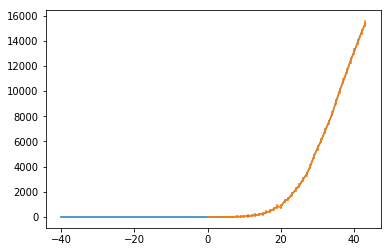

In [4]:
params = mcmc.DiseaseParams()
params.probLethalDailyWhenSeriousUntreated = 0.3
params.probSerious = 0.024 #unknown, higher for older population - should be possible to extract from Diamond Princess. 
#I think about 30 were serious... 30/700 would then be upper limit, so at most 5% for old people. 
#Conistency check: 6(factor below)*11(dead on diamond princess) = 66... okay, more than 30. So 10% serious for old people.
# this number is between 0.02 and 0.1. need to line search max likelihood

params.probLethal = params.probSerious/6 #out of 50~49 serious cases, 7 dead in Aachen study https://www.aerzteblatt.de/archiv/213454
params.probAsymp = 0.3
params.timeIncub = 6  #chinese like studies...
params.timeIncubSigma = 4

#obained to match median 4, IQR 7 from Aachen study https://www.aerzteblatt.de/archiv/213454
params.timeMildToSerious = 7.1 
params.timeMildToSeriousSigma = 13

#Drosten study https://www.medrxiv.org/content/10.1101/2020.03.05.20030502v1 
#: 9 patients, all virus present after 5 days of symptoms. Let's say then that chance shorter ~ 10%. 
# seroconversion early week 2 progressive decrease in viral load in samples. 10 days most gone. 
#let's take lognormal with 5 at 10% CDF and 10 at 90% CDF 
params.timeMildDuration = 7.4 
params.timeMildDurationSigma = 2

# Aachen Median acht Tage (IQR 5–11) for all, including most that did not die. 
# This is longer with larger spread than the recovered group. We choose Median 8.6, IQR 6.6 to get 
params.timeSeriousToDeath = 10
params.timeSeriousToDeathSigma = 6

# less important: 
# Aachen Median 7 Tage [IQR 6–11])
params.timeSeriousToRecovered = 8
params.timeSeriousToRecoveredSigma = 4.5

nPop = 60000000
nPredictDays = 60
maxdelay = 40

#testdays = np.arange(60)

#starting at 21 feb 

#print(np.array(list(df_dict[country]['Cases'].values)))
deaths_data = np.array(list(df_dict[country]['Cases'].values))

#np.array([1,2,3,7,10,12,17,21,29,34,52,79,107,148,197,233,366,463,631,827,827,1266,1441,1809,2158,2503,2978,3405,4032,4825,5476,6077,6820,7503,8215,9134,10023,10779,11591,12428,13155,13915, 14681, 15362 ])
#nPop/(1+np.exp(-(testdays-20)*0.2))*0.0015

deaths_past = np.zeros(maxdelay + deaths_data.size)
deaths_past[maxdelay:] = deaths_data
#keep the relative error low at 1%. if all measurements were independent it would be low.
#but errors even out in time mostly - here we assume a tiny fraction of cases does not 
#besides the constant 

#shot noise: every delta has sigma = sqrt(delta). day i var is cumsum of sigma^2=delta, so the original total. 
#additionally, we assume per day 10 deaths may go unnoticed early in the first two weeks - systematic error... 
#we could also assume a percentage of delta per day is a random added error, but these are not independent and even out late
#while not important initally. 
shotnoise = np.sqrt(deaths_data)
unnoticed = 10*np.ones(deaths_data.shape)
unnoticed[14:] = 0
deaths_error = np.cumsum(unnoticed) + shotnoise
time_past = np.arange(deaths_past.size)-maxdelay
time_data = np.arange(deaths_data.size)
time_all = np.arange(deaths_past.size+nPredictDays)-maxdelay

plt.plot(time_past, deaths_past)
plt.errorbar(time_data, deaths_data, deaths_error)




deathdata = np.zeros((2, deaths_data.size))
deathdata[0, :] = deaths_data
deathdata[1, :] = deaths_error

discontdays = np.array([1, 9, 12, 29]) #removed 32 
discontvals = np.array([1,0.6,0.5,0.4])

discontdata = np.zeros((3, discontdays.size))
discontdata[0, :] = discontdays
discontdata[1, :] = discontvals
discontdata[2, :] = discontvals # > 0 means sample this (else fixed)
#discontdata[2, 1] = -1         # < 0 means fix 

data = mcmc.DiseaseData(deathdata,  discontdata)

data.initialBetaMild = 2
data.initialBetaHigh = 10
data.initialDelay = 23
data.fixBehaviorInAdvance = 10




In [5]:

covid = mcmc.DiseaseSpread(data, params, nPop, 7500, 900.0, maxdelay, nPredictDays)

In [6]:


state = mcmc.State()
state.add(covid)
smooth = mcmc.SmoothnessPrior("behavior",  50, deaths_data.size-data.fixBehaviorInAdvance)
state.add(smooth)

#print(state.getAll())
state.sharedDependencyMaxDepth = 5

In [13]:

target = mcmc.CoolingTarget(9)
target.set_posterior(state)
chain = mcmc.Chain(target, 0)
chain.computeMean = False
chain.recordSamples = True
chain.run(0,0,100,1)
print(chain.getLoglikes())
target = mcmc.CoolingTarget(9)
target.set_posterior(state)
chain = mcmc.Chain(target, 0)
chain.computeMean = False
chain.recordSamples = True
chain.run(0,0,100,1)
print(chain.getLoglikes())


#chain.run(500000,500,500,50)
#chain.run(20,0,20,1)
#chain.run(200000,200,200,50)
#c.run(10,0,20,1)


[-6.6985617  -5.28206999 -5.10745037 -5.48435694 -5.0909954  -6.85639397
 -5.22168007 -5.55271944 -5.07084434 -5.7945045  -5.40070842 -5.3955466
 -5.78264747 -5.26568    -5.20114488 -5.26799555 -5.83185549 -5.47398871
 -5.45002968 -5.52609668 -5.49234196 -5.5200233  -5.38509741 -5.31888419
 -5.52759043 -5.31681034 -5.23909665 -5.41624251 -5.24008311 -5.23861173
 -5.26804004 -5.37626707 -5.21495459 -5.21738033 -5.21453736 -5.21453736
 -5.21235634 -5.21342261 -5.21308788 -5.2308684  -5.25830541 -5.27042481
 -5.21735887 -5.20331505 -5.21096554 -5.20006314 -5.19916611 -5.2210148
 -5.26568906 -5.20257894 -5.19481695 -5.20588298 -5.18756359 -5.19051128
 -5.17077946 -5.18328008 -5.16043484 -5.14593971 -5.15214124 -5.14964579
 -5.15040545 -5.14454308 -5.13349065 -5.12712296 -5.12254872 -5.12545343
 -5.12142884 -5.12271414 -5.1161065  -5.11011023 -5.10554864 -5.10400531
 -5.09891145 -5.0979936  -5.09306426 -5.09122893 -5.09168212 -5.09081861
 -5.09118757 -5.08855307 -5.085034   -5.08641781 -5.0

In [10]:
-13.36 (3x 33-8) -13.55 (33-10, 33-10, 33-10) -13.77 (40-10, 40-10) -13.80 (100-20) 
gd = mcmc.GradientDecent(state, 1e-7)


In [11]:
gd.learningRate = 1e-8;

gd.accelerated_adaptive_gd(10)
#gd.adaptive_gd(100)
#gd.nesterov_accelerated_gd(10)
print(state.loglike())


-28.14990534158586


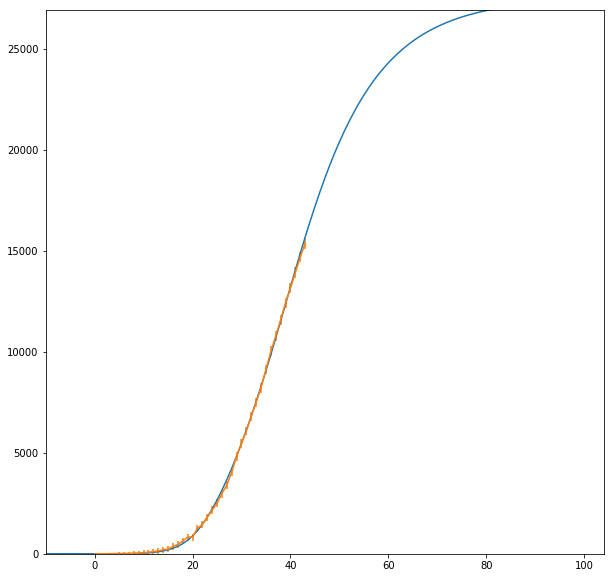

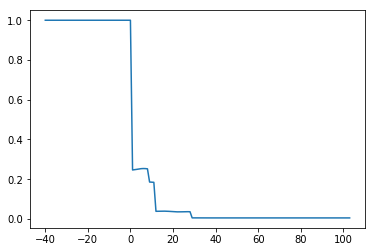

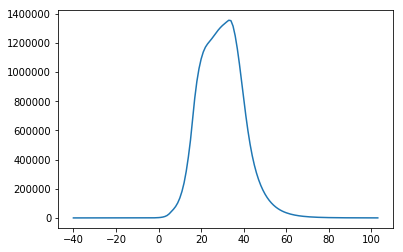

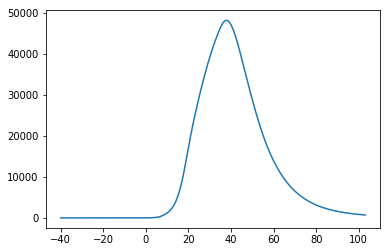

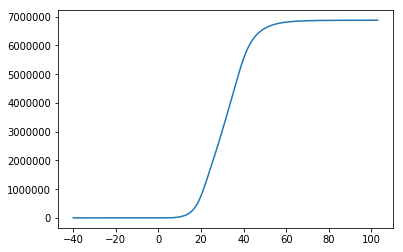

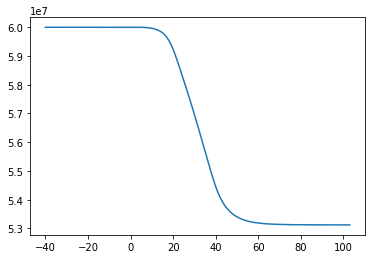

In [12]:
#plt.plot(time_all, chain.getMean("dead")[:] - np.mean(chain.getSamples("dead"),0))
#plt.show()

plt.figure(figsize=(10,10))
plt.plot(time_all, chain.getSamples("dead")[-1,:])
#for i in range(110): 
#    plt.plot(time_all, chain.getSamples("dead")[-1-35*i,:])


plt.errorbar(time_data, deaths_data, deaths_error)
plt.xlim([-10, deaths_data.size+60])

lims = plt.gca().get_xlim()
i = np.where( (time_all > lims[0]) &  (time_all < lims[1]) )[0]
plt.gca().set_ylim( chain.getMean("dead")[i].min(), chain.getMean("dead")[i].max() )

plt.show()


plt.plot(time_all, chain.getSamples("totalBehavior")[-1,:])
plt.show()

plt.plot(time_all, chain.getSamples("mild")[-1,:])
plt.show()
 
plt.plot(time_all, chain.getSamples("serious")[-1,:])
plt.show()
 

plt.plot(time_all, chain.getSamples("recovered")[-1,:])
plt.show()

plt.plot(time_all, nPop-chain.getSamples("recovered")[-1,:])
plt.show()
 


In [94]:
print(chain.getLoglikes())


[-14.72378213 -14.69691309 -14.5043202  -14.19687036 -14.10364518
 -13.9547321  -13.89291947 -14.18519939 -14.21370345 -13.91520173
 -13.88796996 -13.93338715 -13.81261391 -13.88582704 -13.7571053
 -13.75380874 -13.73087384 -13.60721414 -13.60263002 -13.5925589
 -13.58700132 -13.57538814 -13.56033485 -13.54935949 -13.54522206
 -13.54269231 -13.53992813 -13.53748809 -13.5334576  -13.51511059
 -13.50227237 -13.49429406]
